# Neural Classifiers

In [4]:
# Necessary packages
import sys, os, random, math, sys
import torch, spacy
import numpy as np
import pandas as pd
from torch import nn
from tqdm.notebook import trange, tqdm
from matplotlib import pyplot as plt
from torch import optim
from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_ as clip_grad_norm
from torch.nn import functional as F


## Random seeds, to make the results reproducible
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Common functions

In [18]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

# Procesing data

In [25]:
fake = pd.read_csv('Fake.csv', delimiter = ',')
fake['label']= 0
fake = fake.drop(columns=['text','subject','date'])

In [19]:
fake_trn, fake_val, fake_tst = train_validate_test_split(fake, train_percent=0.7, validate_percent=0.2, seed=1)

In [26]:
true = pd.read_csv('True.csv', delimiter = ',')
true['label']= 1
true = true.drop(columns=['text','subject','date'])

In [24]:
true_trn, true_val, true_tst = train_validate_test_split(true, train_percent=0.7, validate_percent=0.2, seed=1)

In [42]:
df_trn, df_val, df_tst = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

df_trn = true_trn.append(fake_trn).sample(frac=1).reset_index(drop=True)
df_val = true_val.append(fake_val).sample(frac=1).reset_index(drop=True)
df_tst = true_tst.append(fake_tst).sample(frac=1).reset_index(drop=True)

print("Training set: " + str(len(df_trn)))
print("Validation set: " + str(len(df_val)))
print("Test set: " + str(len(df_tst)))

Training set: 31427
Validation set: 8979
Test set: 4492


In [100]:
df_trn.to_csv('./preprocessed_data/trn.csv', header=False, index=False)
df_val.to_csv('./preprocessed_data/val.csv', header=False, index=False)
df_tst.to_csv('./preprocessed_data/tst.csv', header=False, index=False)

## 1. Load Data

The following **reader()** function will do three things

- read texts from files (line 22 - 25)
- build a vocab based on training data (line 29)
- convert each set (training, val, test) into a collection of mini-batch vector (line 35 - 39)

The **input** to the neural network model defined in the next section is mini-batch word index matrix $\bf{X}$
$$\bf{X} = [\bf{x},\dots,\bf{x}_B]$$
where each $\bf{x}_i$ is a **column** vector containing word indices from an input text. $B$ is the mini-batch size as explained in the lacture.

Sentences in a mini-batch usually have different lengths. To form a matrix $\bf{X}$, a simple trick is to add a special token \<pad\> at the end of shorter sentences. For example, consider the two text examples in the lecture 

- I like coffee .
- I don t like tea .

To make these two examples have the same length, the preprocessing code will add two special \<pad\> tokens at the end of the first sentence 

- I like coffee . \<pad\> \<pad\>

### 1.1 Define the data processing functions

In [104]:
from torchtext.data import Field, ReversibleField, Dataset, TabularDataset, BucketIterator, Iterator

# Download the 'en' module for spaCy using
#  'python -m spacy download en'

# spacy_en = spacy.load('en')

def tokenize_fn(text):
    """ Tokenization function
    """
    # return [tok.text for tok in spacy_en.tokenizer(text)]
    return text.strip().split()


def reader(suffix=".csv", rpath="./preprocessed_data/", batch_size=8, min_freq=2):
    """
    - suffix: data file suffix
    - rpath: path to the data files
    - batch_size: mini-batch size
    - min_freq: word frequency cutoff, frequency less than min_freq will be removed when building the vocab
    """
    # Utterance Field: title
    TXT = Field(sequential=True, tokenize=tokenize_fn, init_token=None, eos_token=None, lower=True)
    LABEL = Field(sequential=False, unk_token=None, dtype=torch.long, use_vocab=False)
    
    # Create a Dataset for titles
    fields = [("text", TXT), ("label", LABEL)]
    trn_data = TabularDataset(os.path.join(rpath,'trn'+suffix), format="CSV", fields=fields, skip_header=False)
    val_data = TabularDataset(os.path.join(rpath,'val'+suffix), format="CSV", fields=fields, skip_header=False)
    tst_data = TabularDataset(os.path.join(rpath,'tst'+suffix), format="CSV", fields=fields, skip_header=False)
    
    # Split
    # Build vocab using training data
    TXT.build_vocab(trn_data, min_freq=min_freq) # or max_size=10000
    # 
    train_iter, val_iter, test_iter = BucketIterator.splits((trn_data, val_data, tst_data), # data
                                                             batch_size=batch_size, # 
                                                             sort=True, # sort_key not specified
                                                             sort_key = lambda x : len(x.text),
                                                             shuffle=False, # shuffle between epochs
                                                             repeat=False)
    return train_iter, val_iter, test_iter, TXT

### 1.2 Processing the SST dataset

Calling the previously defined functions to process the data. Potentially useful hyper-parameters in the following code block

- **batch_size**: the number of training examples in each mini batch, default value: 16
- **min_freq**: the cutoff threshold of low-frequency words, default value: 1 (no cutoff)

In [105]:
train_iter, val_iter, test_iter, txtfield = reader(suffix=".csv", rpath="./preprocessed_data/", batch_size=16, min_freq=1)
vocab_size = len(txtfield.vocab)
# print(txtfield.vocab.freqs)
print("Vocab size = {}".format(vocab_size))
pad = txtfield.vocab.stoi[txtfield.pad_token]

print("[TRAIN]:%d (dataset:%d)\t[VAL]:%d (dataset:%d)\t[TEST]:%d (dataset:%d)"
    % (len(train_iter), len(train_iter.dataset),
    len(val_iter), len(val_iter.dataset),
    len(test_iter), len(test_iter.dataset)))
print("[vocab]:%d" % (vocab_size))

/Data/miniconda3/envs/ai/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/Data/miniconda3/envs/ai/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/Data/miniconda3/envs/ai/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent rel

## 2. A Simple Feed-forward Neural Network Classifier

The goal of this section is to demonstrate 

- how to define a simple neural text classifier
- how to train the neural network model with the BP algorithm

### 2.1 Define Neural Network Models

This section defines a basic neural network model (as illustrated in the following figure) for text classification. 

<img src="https://yangfengji.net/uva-nlp-course/code/figures/nns.png" alt="drawing" width="300"/>

There are two basic components of definiing neural network models in PyTorch

- __ init __ (): Initialize an instance
- forward(): Forward computation, the network architecture is specified in this function

In [71]:
class NeuralClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, drop_rate=0.0, class_size=2, pad=1):
        super(NeuralClassifier, self).__init__()
        """ Initialization
        - vocab_size
        - embed_size: word embedding size
        - drop_rate: dropout rate
        - class_size: number of classes. For binary classification, class_size = 2
        """
        # ---------------------------------
        # Configuration
        self.vocab_size = vocab_size # size of the vocab
        self.class_size = class_size # number of classes
        self.dropout = nn.Dropout(drop_rate)
        self.pad = pad
        # ---------------------------------
        # Network parameters
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=pad)
        self.fc = nn.Linear(embed_size, class_size, bias=True)


    def forward(self, batch):
        """ Forward function
        """
        input, label = batch.text, batch.label
        
        # ---------------------------------
        # === Hidden layer ===
        # Sum over all the embeddings for each input text
        #   then, pass through the nonlinear Sigmoid function
        x = self.embed(input) # Dim: L x B x E
        x = self.dropout(x)
        hidden = torch.sigmoid(x.sum(axis=0)) # Dim: B x E
        
        # ---------------------------------
        # === Classification layer ===
        logit = self.fc(hidden) # Dim: Batch_size x Class_size
        # Normalization
        logprob = F.log_softmax(logit, dim=1)
        
        # ---------------------------------
        # === Loss function ===
        # Compute negative log-likelihood loss
        loss = F.cross_entropy(logprob, label)
        return loss, logprob


### 2.2 A Convolutional Neural Network Classifier

In this section, we will build a CNN classifier based on the specific instructions given in the homework assignment. Mostly, we re-use the data processing code provided in section 1 and the training code provided in section 2.3. In order to train the CNN classifier instead of the simple feedforward neural network classifiers, 
you need to replace code line 7 in section 2.2.2 with the following line:

```Python
    model = NeuralClassifier(vocab_size, embed_size=64, drop_rate=0.0, class_size=2)
```

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, drop_rate=0.0,
                 class_size=2, kernel_sizes=[2,3,4],
                 dropout=0.0, using_cuda=False, pad=None):
        super(SimpleCNN, self).__init__()
        # ---------------------------------
        # Configuration
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.class_size = class_size # number of classes
        self.kernel_sizes = kernel_sizes # a list of kernel sizes
        self.using_cuda = using_cuda
        self.pad = pad # index of <pad> in vocab
        # ---------------------------------
        # Model Arch
        # Remove the following line and define some parameters for the CNN model here
        raise NotImplementedError("Not done yet")


    def forward(self, batch):
        # ===============================
        # Implement the CNN specified in the homework
        
        # ===============================
        
        logprob = F.log_softmax(logit, dim=1)
        loss = F.cross_entropy(logprob, label)
        return loss, logprob

## 2.3 Neural Network Training

### 2.2.1 Additional functions for mini-batch training and evaluation

Define the training function with a mini-batch


In [72]:

def batch_train(batch, model, optimizer):
    """ Training with one batch
    - batch: a min-batch of the data
    - model: the defined neural network
    - optimizer: optimization method used to update the parameters
    """
    # set in training mode
    model.train()
    # initialize optimizer
    optimizer.zero_grad()
    # forward: prediction
    loss, _ = model(batch)
    # backward: gradient computation
    loss.backward()
    # norm clipping, in case the gradient norm is too large
    clip_grad_norm(model.parameters(), grad_clip)
    # gradient-based update parameter
    optimizer.step()
    return model, loss.item()

Define the evaluation function

In [73]:
def eval(data_iter, model):
    """ Evaluate the model with the data
    data_iter: the data iterator 
    model: the defined model
    """
    # set in the eval model, which will trun off the features only used for training, such as dropout
    model.eval()
    # records
    val_loss, val_batch = 0, 0
    total_example, correct_pred = 0, 0
    # iterate all the mini batches for evaluation
    for b, batch in enumerate(data_iter):
        # Forward: prediction
        loss, logprob = model(batch)
        # 
        val_batch += 1
        val_loss += loss
        # Argmax
        max_logprob, pred_label = torch.max(logprob, -1)
        correct_pred += (pred_label==batch.label).sum()
        total_example += batch.label.size()[0]
    acc = (1.0*correct_pred)/total_example
    # print("val_batch = {}".format(val_batch))
    return (val_loss/val_batch), acc

### 2.2.2 Main function for training

There are four blocks in the following code

1. Reset the random seed to make sure that everytime you run the following code will get the same results (with the same hyper-parameters)
2. Define the model and optimizers. Potentially useful hyper-parameters in this block
    - **embed_size**: Word embedding size, default value: 64
    - **drop_rate**: Dropout rate, default value: 0 (no dropout)
    - **lr**: Initial learning rate ($\eta_0$), default value: 0.1
    - **weight_decay**: $\ell_2$ regularization parameter, default value: 0 (no $\ell_2$ regularization)
3. Define the numbers of total training epochs and the number of updating steps for calling the validation function. Potentially useful hyper-parameters in this block
    - **epoch**: Total training epoch, default value: 5
    - **val_step**: Validation steps, default value: 50
4. The main function of training

In [106]:
# -----------------------------------
# 1. Random seed
torch.manual_seed(seed)

# ------------------------------------
# 2. Define the model and optimizer
# 'ffn': Feed-forward network; 'cnn': Convolutional neural network
model_name = 'ffn' 
if model_name == 'ffn':
    model = NeuralClassifier(vocab_size, embed_size=64, drop_rate=0.0, class_size=2)
elif model_name == 'cnn':
    model = SimpleCNN(vocab_size, embed_size=64, drop_rate=0.0, class_size=2)
else:
    raise ValueError("Unrecognized model name")
# optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-1, weight_decay=0)
# the norm of grad clipping
grad_clip = 1.0

# ------------------------------------
# 3. Define the numbers of training epochs and validation steps
epoch, val_step = 5, 50

# ------------------------------------
# 4. Training iterations
TrnLoss, ValLoss, ValAcc = [], [], []
total_batch = 0
for e in trange(epoch):
    # print(e)
    for b, batch in enumerate(train_iter):
        total_batch += 1
        # Update parameters with one batch
        model, loss = batch_train(batch, model, optimizer)
        # Compute validation loss after each val_step
        if total_batch % val_step == 0:
            val_loss, val_acc = eval(val_iter, model)
            ValLoss.append(val_loss)
            ValAcc.append(val_acc)
            TrnLoss.append(loss)
print("The best validation accuracy = {:.4}".format(max(ValAcc)))

  0%|          | 0/5 [00:00<?, ?it/s]

/Data/miniconda3/envs/ai/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
The best validation accuracy = 0.7721


Plot the training and validation losses along the training steps (each step involves updating with one mini-batch of the training examples). 

Although the validation loss *fluctuates* along with updating, the over tendency is decreasing, which means the model is learning some information that is useful for prediction.

An alterative way of visualizing the following curves dynamically is using [tensorboard](https://pytorch.org/docs/stable/tensorboard.html), which will not be covered in this class.

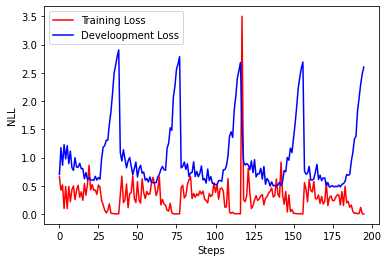

In [107]:
plt.plot(range(len(TrnLoss)), TrnLoss, color="red", label="Training Loss") # Training loss
plt.plot(range(len(ValLoss)), ValLoss, color="blue", label="Develoopment Loss") # Val loss
plt.xlabel("Steps")
plt.ylabel("NLL")
plt.legend()

In [109]:
eval(test_iter, model)

/Data/miniconda3/envs/ai/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


(tensor(2.6899, grad_fn=<DivBackward0>), tensor(0.5247))